# Web Scraping Project
Well as it turns out, it's probably a bit of a misnomer to call the project I chose as a web scraping project. As it turns out it was much more a document scraping focused project than a web-focused one. While I did pull comments from two different reddit posts to gather my data, most of the effort involved using a lot of regular expressions to clean the data. First, to get it into a state where it could be converted into a data frame structure and second, to clean and categorize the data in each column. When I say it took a lot of regular expressions, I mean it took. A lot. Of Regular Expressions.

## 

In [627]:
# Import packages for scraping/processing data
import re
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy
import pandas as pd
import requests
import seaborn as sns
from bs4 import BeautifulSoup

euro_exchange_2019 = 1.1220  # Exchange rate on Dec 31, 2019
gbp_exchange_2019 = 1.3247  # Exchange rate on Dec 31, 2019
euro_exchange_2020 = 1.2214  # Exchange rate on Dec 31, 2020
gbp_exchange_2020 = 1.3657  # Exchange rate on Dec 31, 2020

In [10]:
ds_2019 = "https://old.reddit.com/r/datascience/comments/e8fown/official_2019_end_of_year_salary_sharing_thread/?limit=500"
ds_2020 = "https://old.reddit.com/r/datascience/comments/klvb55/official_2020_end_of_year_salary_sharing_thread/?limit=500"

ds_2019_response = requests.get(
    ds_2019, headers={"User-agent": "ew da6223 webscraping project"}
)
time.sleep(3)
ds_2020_response = requests.get(
    ds_2020, headers={"User-agent": "ew da6223 webscraping project"}
)

In [11]:
print(ds_2019_response)
print(ds_2020_response)

<Response [200]>
<Response [200]>


In [12]:
ds_2019_page_content = BeautifulSoup(ds_2019_response.text, "html.parser")
ds_2020_page_content = BeautifulSoup(ds_2020_response.text, "html.parser")

## com

In [864]:
def extract_records(ds_page_content, debug=False):
    ds_comments_div = ds_page_content.select(".md")
    has_record_bool = list()
    for comment in ds_comments_div:
        if re.search("Title:", str(comment)):
            has_record_bool.append(True)
        else:
            has_record_bool.append(False)

    ds_salary_records = [i for (i, v) in zip(ds_comments_div, has_record_bool) if v]
    ds_salary_records_dicts = list()
    record_number = 0
    for record in ds_salary_records[1:]:
        record_number += 1
        record_dict = {}
        if debug:
            print(record)
        record = re.sub(r"\<\/?strong\>|\‘", "", str(record))
        record = re.sub(r"\<\/?p\>", "", str(record))
        record = re.sub(r"\<\/?ul\>", "", str(record))
        record = re.sub(
            r"(<li>Prior Experience\:)\s?\n+\<\/?li\>([A-z0-9\s\(\=\)\:]+)\<\/?li\>\n+\<\/?li\>([A-z0-9\s\(\=\)]+)\<\/?li\>\n+\<\/?li\>([A-z0-9\s\(\=\)]+)\<\/?li\>\n+",
            r"\1 \2, \3, \4",
            str(record),
        )
        record = re.sub(
            r"(<li>Prior Experience\:)\s?\n+\<\/?li\>([A-z0-9\s\(\=\)\:]+)\<\/?li\>\n+\<\/?li\>([A-z0-9\s\(\=\)]+)\<\/?li\>\n+",
            r"\1 \2, \3",
            str(record),
        )
        record = re.sub(
            r"(<li>Prior Experience\:)\s?\n+\<\/?li\>([A-z0-9\s\(\=\)\:]+)\<\/?li\>\n+",
            r"\1 \2",
            str(record),
        )
        record = re.sub(r"\$(Internship|Coop)\s([A-z0-9]+)", r"\1: \2", str(record))
        record = re.sub(r"\$(Internship|Coop)(<\/li>)", r"\1: None\2", str(record))
        record = re.sub(r"\$(Internship|Coop)", r"\1", str(record))
        record = re.sub(r"(remote)\:", r"\1", str(record))
        record = re.sub(r"([Cc]ompany\/)", r"", str(record))
        record = re.sub(r"([Cc]ompany):", r"Industry", str(record))
        record = re.sub(r"(BS):", r"\1", str(record))
        record = re.sub(r"(Data Analyst):", r"\1", str(record))
        record = re.sub(r"(Data Scientist):", r"\1", str(record))
        record = re.sub(r":( Aviation)", r"\1", str(record))
        record = re.sub(
            r"(<li>[A-Za-z0-9\s\$\/\-\~,\'\(\)\|\=\.\+\%\;]+)\s?([A-Za-z0-9\s\$\/\-\~,\'\(\)\|\=\.\+\%\;]+<\/li>\n?)",
            r"",
            str(record),
        )
        if debug:
            print(record)
        record_title = re.search(
            "[Tt]itle:\s?([A-z0-9\s\(\)\/\-\.\,\%'\"\&\;]+)[<\n]", record
        )
        if debug:
            print(record_title, record_title[1])
        record_tenure = re.search(
            "[Tt]enure(?: [Ll]ength)?:\s?([A-z0-9\s\(\)\/\-\.\,\%'\;\&]+)[<\n]", record
        )
        if record_tenure == None:
            record_tenure = ["filler", "none given"]
        record_location = re.search(
            "[Ll]ocation:\s?([A-z0-9\s\(\)\/\-\.\,\%'\;]+)[<\n]", record
        )
        if record_location == None:
            record_location = ["filler", "none given"]
        record_salary = re.search(
            "(?:[Ss]alary|[Bb]ase):\s?([A-z0-9\s\(\)\/\-\.\,\%'\;\$\€\~\£\+\‘]+)[<\n]",
            record,
        )
        record_industry = re.search(
            "[Ii]ndustry:?\s?([A-z0-9\s\(\)\/\-\.\,\%'\;\$\€\~\£\+\&]+)[<\n]", record
        )
        if record_industry == None:
            record_industry = ["filler", "none given"]
        record_education = re.search(
            "[Ee]ducation:?\s?([A-z0-9\s\(\)\/\-\.\,\%'\;\$\€\~\£\+\&\|\’]+)[<\n]",
            record,
        )
        if record_education == None:
            record_education = ["filler", "none given"]
        record_prior_experience = re.search(
            "(?:[Pp]rior)?\s?(?:[Ee]xperience|[Ee]xp):?\s?([A-z0-9\s\(\)\/\-\.\,\%'\;\$\€\~\£\+\&\=\@\"]+)[<\n]",
            record,
        )
        if record_prior_experience == None:
            record_prior_experience = ["filler", "none given"]
        record_total_comp = re.search(
            "[Tt]otal (?:[Cc]omp|[Cc]ompensation):?\s?([A-z0-9\s\(\)\/\-\.\,\%'\;\$\€\~\£\+\&\;\?]+)[<\n]",
            record,
        )
        if record_total_comp == None:
            record_total_comp = ["filler", "none given"]
        record_dict["title"] = record_title[1]
        record_dict["tenure"] = record_tenure[1]
        record_dict["location"] = record_location[1]
        record_dict["salary"] = record_salary[1]
        record_dict["industry"] = record_industry[1]
        record_dict["education"] = record_education[1]
        record_dict["prior_experience"] = record_prior_experience[1]
        record_dict["total_comp"] = record_total_comp[1]
        if debug:
            print(record_dict)
        ds_salary_records_dicts.append(record_dict)
    return ds_salary_records_dicts

In [865]:
ds_2019_df = pd.DataFrame(extract_records(ds_2019_page_content))
ds_2020_df = pd.DataFrame(extract_records(ds_2020_page_content))

In [866]:
def wrangle_title(ds_df, debug=False):
    title_level_list = []
    for title_name in ds_df["title"]:
        if debug:
            print(title_name)
        if (
            re.search(
                "([Dd]irector|[Hh]ead|[Pp]rincipal|[Mm]anager [Dd]ata|[Dd][Ss]\s?[Mm]anager|Data Science Manager|Informatics Manager)",
                title_name,
            )
            != None
        ):
            wrangled_title = "leader"
        elif re.search("([Ss]r.|[Ss]enior|[Pp]rincipal|[Hh]ead)", title_name) != None:
            wrangled_title = "senior"
        elif (
            re.search(
                "[Dd]ata [Ss]cientist|[Ee]ngineer|[Dd]eveloper|[Mm]achine\s?[Ll]earning|[Cc]onsultant|Data Manager|[Dd]ecision",
                title_name,
            )
            != None
        ):
            wrangled_title = "scientist/engineer"
        elif (
            re.search(
                "([Aa]nalyst|[Aa]nalytics|[Aa]ssociate|[Rr]esearch|[Mm]arketing|[Qq]uant)",
                title_name,
            )
            != None
        ):
            wrangled_title = "analyst"
        else:
            wrangled_title = "No Title Given"
        if debug:
            print(
                "Orig Title: {}   Title Category: {}".format(title_name, wrangled_title)
            )
        title_level_list.append(wrangled_title)
    return title_level_list


ds_2019_df["title_level"] = wrangle_title(ds_2019_df)
ds_2020_df["title_level"] = wrangle_title(ds_2020_df)

In [867]:
def wrangle_salary(ds_df, euro_exchange_rate, gbp_exchange_rate, debug=False):
    wrangled_salary_values = []
    for salary_value in ds_df["salary"]:
        if debug:
            print(salary_value)
        wrangled_value = re.sub("([0-9]+)[.,]([0-9])[Kk]", r"\1\2 00", salary_value)
        wrangled_value = re.sub("([0-9+])\s(00)", r"\1\2", wrangled_value)
        wrangled_value = re.sub("\.", ",", wrangled_value)
        wrangled_value = re.sub(",0000", ",000", wrangled_value)
        wrangled_value = re.sub("480,000dkk \(|16lpa \(", "", wrangled_value)
        if debug:
            print(wrangled_value)
        wrangled_value = re.sub(
            "(\,|\~| base|\s?[Uu][Ss][Dd]\s?|12 lakh annully/ | per year|\$)",
            r"",
            wrangled_value,
        )
        wrangled_value = re.sub(
            "(Industry academia/public health|Industry Tech/Music)",
            r"0",
            wrangled_value,
        )
        wrangled_value = re.sub("\s?[Kk]", r"000", wrangled_value)
        wrangled_value = re.sub("800\-900\/mo", "10200", wrangled_value)
        wrangled_value = re.sub("([0-9]+)\sEUR", r"€\1", wrangled_value)
        if re.search("\€", wrangled_value) != None:
            euro_value = int(re.search("\€?([0-9]+)\€?", wrangled_value)[1])
            dollar_value = str(int(euro_value * euro_exchange_rate))
            wrangled_value = re.sub("(\€?[0-9]+\€?)", dollar_value, wrangled_value)
        if re.search("\£", wrangled_value) != None:
            gbp_value = int(re.search("\£([0-9]+)", wrangled_value)[1])
            dollar_value = str(int(gbp_value * gbp_exchange_rate))
            wrangled_value = re.sub("\£([0-9]+)", dollar_value, wrangled_value)
        wrangled_value = int(re.match("\s?[0-9]+", wrangled_value).group())
        if debug:
            print(wrangled_value)
        wrangled_salary_values.append(wrangled_value)
    return wrangled_salary_values


ds_2019_df["salary_num"] = wrangle_salary(
    ds_2019_df, gbp_exchange_2019, euro_exchange_2019
)
ds_2020_df["salary_num"] = wrangle_salary(
    ds_2020_df, gbp_exchange_2020, euro_exchange_2020
)

In [868]:
def wrangle_tenure(ds_df, debug=False):
    wrangled_tenure_values = []
    for tenure_val in ds_df["tenure"]:
        if debug:
            print(tenure_val)
        wrangled_tenure = re.sub("Five", "5", tenure_val)
        wrangled_tenure = re.sub("\&lt\;\s?", "", wrangled_tenure)
        wrangled_tenure = re.sub("a few months", "< 1 year", wrangled_tenure)
        wrangled_tenure = re.sub(
            "1 and half years|just wrapped up my 1st year", "1 year", wrangled_tenure
        )
        #     print(wrangled_tenure, ", pre-line9")
        if re.search("([0-9]+)\s?[Mm]on?t?h?s?|[Ww]eek", wrangled_tenure) != None:
            num_months = int(
                re.search(
                    "([0-9]+)(?:\s?[Mm]on?t?h?s?|\s?[Ww]eeks)", wrangled_tenure
                ).group(1)
            )
            if num_months < 12:
                wrangled_tenure = "< 1 year"
            else:
                wrangled_tenure = "1-2 years"
        if (
            re.search(
                "([0-9\.]+)(?:\s?[Yy]ears?|\s?[Yy]r|\s?[Yy]eaers|\s?[Yy])",
                wrangled_tenure,
            )
            != None
        ):
            num_years = float(
                re.search(
                    "([0-9\.]+)(?:\s?[Yy]ears?|\s?[Yy]r|\s?[Yy]eaers|\s?[Yy])",
                    wrangled_tenure,
                ).group(1)
            )
            if num_years < 1.0:
                wrangled_tenure = "< 1 year"
            elif (num_years >= 1.0) & (num_years <= 2.0):
                wrangled_tenure = "1-2 years"
            else:
                wrangled_tenure = "> 2 years"
        if re.search("[Ss]tart|[Ff]rom", wrangled_tenure) != None:
            wrangled_tenure = "< 1 year"
        if re.search("^2.5", wrangled_tenure) != None:
            wrangled_tenure = "> 2 years"
        if re.search("5", wrangled_tenure) != None:
            wrangled_tenure = "> 2 years"
        if debug:
            print(wrangled_tenure)
        wrangled_tenure_values.append(wrangled_tenure)
    return wrangled_tenure_values


ds_2019_df["tenure_category"] = wrangle_tenure(ds_2019_df)
ds_2020_df["tenure_category"] = wrangle_tenure(ds_2020_df)

In [869]:
def wrangle_location(ds_df, debug=False):
    wrangled_place_values = []
    for place in ds_df["location"]:
        if debug:
            print(place)
        wrangled_place = place
        if (
            re.search(
                "[Ss]acramento|[Ss]o[Cc]al|[Aa]rizona|[L]os\s?[Aa]ngeles|LA|[Dd]enver|[Pp]hoenix|[Ww]est\s?[Cc]oast|[Rr]iverside",
                place,
            )
            != None
        ):
            wrangled_place = "west coast"
        if (
            re.search(
                "[Ss]eattle|[Ss][Ff]|[Ss]an\s?[Ff]rancisco|[Bb]ay\s?[Aa]rea|highest COL|Pacific NW|[Ss]ilicon",
                wrangled_place,
            )
            != None
        ):
            wrangled_place = "bay area/seattle"
        if (
            re.search(
                "[Dd]own\s?[Uu]nder|[Gg]ermany|[Aa]msterdam|[Ii]ndia|[Ss]cotland|[Ss]weden|[Nn]etherlands|[Ee]urope|[Pp]hilippines|[Ll]ondon|[Aa]ustria|[Dd]enmark|[Cc]anada|Czech|Singapore|Lebanon|Brussels|Toronto|Italy|Belarus|Ireland|Switzerland",
                wrangled_place,
            )
            != None
        ):
            wrangled_place = "international"
        if (
            re.search(
                "[Mm]idwest|[Aa]tlanta|[Mm]inneapolis|[Ff]lorida|[Dd][Ff][Ww]|[Dd]allas|[Tt][Xx]|[Mm]iami|[Hh]ouston|[Ss]t\.?\s?[Ll]ouis|[Bb]oonies|[Oo]hio|[Oo][Hh]|[Aa]?r?[Kk]ansas|[Cc]hicago|[Tt][Nn]|[Cc]arolina|[Dd]etroit|Southeast|Between|Tennessee",
                wrangled_place,
            )
            != None
        ):
            wrangled_place = "south/midwest"
        if (
            re.search(
                "[Pp]ennsylvania|[Nn][Jj]|[Dd]\.?[Cc]\.?|[Nn][Yy][Cc]|[Bb]oston|[Pp]hilly|Baltimore|East|Connecticut|Jersey|Cambridge, MA|Philadelphia|New England",
                wrangled_place,
            )
            != None
        ):
            wrangled_place = "east coast"
        if re.search("[Rr]emote|[Mm]y\s?[Hh]ome|DMV", wrangled_place) != None:
            wrangled_place = "none given"
        if debug:
            print(wrangled_place)
        wrangled_place_values.append(wrangled_place)
    return wrangled_place_values


ds_2019_df["location_category"] = wrangle_location(ds_2019_df)
ds_2020_df["location_category"] = wrangle_location(ds_2020_df)

In [870]:
def wrangle_industry(ds_df, debug=False):
    wrangled_industry_values = []
    for ind in ds_df["industry"]:
        wrangled_ind = ind
        if (
            re.search(
                "[Ff]ina?n?c?|[Pp]orto?folio|[Bb]ank|[Ii]nsur|[Cc]redit|[Tt]rading|[Vv][Cc]",
                wrangled_ind,
            )
            != None
        ):
            wrangled_ind = "Finance/Insurance"
        if (
            re.search("[Mm]edical|[Mm]ed[Tt]ech|[Hh]ealth|[Pp]harma", wrangled_ind)
            != None
        ):
            wrangled_ind = "Health/Pharmaceuticals"
        if (
            re.search(
                "[Rr]etail|[Cc]onsumer|[Cc][Pp][Gg]|[Mm]arketing|[Aa]d\s?[Tt]ech|[Ee]\-?[Cc]ommerce|[Ll]ogistics|[Ww]arehous|[Aa]dvertising|Distribution",
                wrangled_ind,
            )
            != None
        ):
            wrangled_ind = "Retail/Ecommerce/Marketing/Logistics"
        if (
            re.search(
                "[Ss]aa[Ss]|[Mm]edia|IT|[Tt]ech|[Uu]ber|[Ee]ntertainment|[Aa]uto|internet|[Dd]igital|cable",
                wrangled_ind,
            )
            != None
        ):
            wrangled_ind = "Tech"
        if (
            re.search("[Ff][Bb]|[A]mazon|[Bb]ig\s?4|[Ff][Aa]{2}[Nn][Gg]", wrangled_ind)
            != None
        ):
            wrangled_ind = "Tech"  # "FAANG"
        if (
            re.search(
                "[Uu]tility|[Dd]efense|[Ll]egal|[Ee]nergy|[Gg]as|[Oo]il|[Ff]ederal|[Gg]overnment",
                wrangled_ind,
            )
            != None
        ):
            wrangled_ind = "Govt/Energy/Defense"
        if (
            re.search(
                "[Aa]cademia|[Nn]\/[Aa]|[Ff]ortune|[Nn]one|[Cc]onsult|[Ee]ducation|[Nn]onprofit|[Tt]ravel|fast food|[Ss]tartup|external clients|social enterprise|Services|Market Research",
                wrangled_ind,
            )
            != None
        ):
            wrangled_ind = "Other/Unknown"
        if (
            re.search(
                "^ $",
                wrangled_ind,
            )
            != None
        ):
            wrangled_ind = "Other/Unknown"
        if debug:
            print(wrangled_ind)
        wrangled_industry_values.append(wrangled_ind)
    return wrangled_industry_values


ds_2019_df["industry_category"] = wrangle_industry(ds_2019_df)
ds_2020_df["industry_category"] = wrangle_industry(ds_2020_df)

In [871]:
def wrangle_education(ds_df, debug=False):
    education_wrangled = []
    for ed in ds_df["education"]:
        if debug:
            print(ed)
        ed_wrangled = ed
        if re.search("[Pp][Hh]\.?[Dd]\.?", ed_wrangled) != None:
            ed_wrangled = "doctorate"
        elif re.search("[Mm][Ss]|[Mm]aster|[Mm]\.[Aa]\.|M.Ed.|MA", ed_wrangled) != None:
            ed_wrangled = "masters"
        elif (
            re.search(
                "[Bb]achelor|[Bb][Ss]|[Bb][Aa]|[Bb]\.[Ss]|[Uu]ndergrad|QS|College Diploma",
                ed_wrangled,
            )
            != None
        ):
            ed_wrangled = "bachelors"
        else:
            ed_wrangled = "< bachelors"
        if debug:
            print(ed_wrangled)
        education_wrangled.append(ed_wrangled)
    return education_wrangled


ds_2019_df["highest_education_category"] = wrangle_education(ds_2019_df)
ds_2020_df["highest_education_category"] = wrangle_education(ds_2020_df)

In [872]:
def wrangle_totalcomp(ds_df, euro_exchange_rate, gbp_exchange_rate, debug=False):
    totalcomp_wrangled = []
    for tc in ds_df["total_comp"]:
        if debug:
            print(tc)
        tc_wrangled = tc
        tc_wrangled = re.sub("14 lakh\/ |~|\$|\&gt\;|\,", "", tc_wrangled)
        tc_wrangled = re.sub("800\-900\/mo", "10200", tc_wrangled)
        tc_wrangled = re.sub("\.000", "000", tc_wrangled)
        tc_wrangled = re.sub("18-19 lpa \(", "", tc_wrangled)
        if re.search("[£]", tc_wrangled) != None:
            in_gbp = True
        else:
            in_gbp = False
        if re.search("[€]", tc_wrangled) != None:
            in_euro = True
        else:
            in_euro = False
        if (
            re.search(
                "\£?([0-9]{2,3}[0-9]?[0-9]?[0-9]?[Kk]?)\s?\-\s?\£?([0-9]{2,3}[0-9]?[0-9]?[0-9]?[Kk]?)",
                tc_wrangled,
            )
            != None
        ):
            match_obj = re.search(
                "\£?([0-9]{2,3}[0-9]?[0-9]?[0-9]?[Kk]?)\s?\-\s?\£?([0-9]{2,3}[0-9]?[0-9]?[0-9]?[Kk]?)",
                tc_wrangled,
            )
            range_obj1 = match_obj.group(1)
            range_obj2 = match_obj.group(2)
            if re.search("[Kk]", range_obj1) != None:
                range_obj1 = re.sub("([0-9]{1,3})[Kk]", "\g<1>000", range_obj1)
            if len(range_obj1) in [2, 3]:
                range_obj1 = re.sub("([0-9]{2,3})", "\g<1>000", range_obj1)
            if re.search("[Kk]", range_obj2) != None:
                range_obj2 = re.sub("([0-9]{1,3})[Kk]", "\g<1>000", range_obj2)
            if len(range_obj2) in [2, 3]:
                range_obj2 = re.sub("([0-9]{2,3})", "\g<1>000", range_obj2)
            if in_gbp:
                range_obj1 = int(float(range_obj1) * gbp_exchange_rate)
                range_obj2 = int(float(range_obj2) * gbp_exchange_rate)
                in_gbp = False
            if in_euro:
                range_obj1 = int(float(range_obj1) * euro_exchange_rate)
                range_obj2 = int(float(range_obj2) * euro_exchange_rate)
                in_euro = False
            tc_wrangled = str(int((int(range_obj1) + int(range_obj2)) / 2))
        if in_gbp:
            gbp_val = re.search("\£([0-9]{1,3}[0-9]?[0-9]?[0-9]?)", tc_wrangled).group(
                1
            )
            tc_wrangled = str(int(float(gbp_val) * float(gbp_exchange_rate)))
        if in_euro:
            euro_val = re.search(
                "\€?([0-9]{1,3}[0-9]?[0-9]?[0-9]?)\€?", tc_wrangled
            ).group(1)
            tc_wrangled = str(int(float(euro_val) * float(euro_exchange_rate)))
        tc_wrangled = re.sub("([0-9]{2,3})\.([0-9])[Kk]", "\g<1>\g<2>00", tc_wrangled)
        tc_wrangled = re.sub("([0-9]{2,3})[Kk]", "\g<1>000", tc_wrangled)
        if re.search("([0-9]{5,6})", tc_wrangled) != None:
            tc_wrangled = re.search("([0-9]{5,6})", tc_wrangled).group(1)
        if re.search("^([0-9]+)", tc_wrangled) == None:
            tc_wrangled = "none given"
        if debug:
            print(tc_wrangled)
        totalcomp_wrangled.append(tc_wrangled)
    return totalcomp_wrangled


ds_2019_df["total_comp_num"] = wrangle_totalcomp(
    ds_2019_df, euro_exchange_2019, gbp_exchange_2019
)
ds_2020_df["total_comp_num"] = wrangle_totalcomp(
    ds_2020_df, euro_exchange_2020, gbp_exchange_2020
)

In [873]:
ds_2019_df["year"] = "2019"
ds_2020_df["year"] = "2020"
reddit_ds_df = pd.concat([ds_2019_df, ds_2020_df]).reset_index()

reddit_ds_df["title_level"] = pd.Categorical(
    reddit_ds_df["title_level"],
    categories=["analyst", "scientist/engineer", "senior", "leader"],
    ordered=True,
)
reddit_ds_df["tenure_category"] = pd.Categorical(
    reddit_ds_df["tenure_category"],
    categories=["< 1 year", "1-2 years", "> 2 years"],
    ordered=True,
)
reddit_ds_df["location_category"] = pd.Categorical(
    reddit_ds_df["location_category"],
    categories=[
        "international",
        "bay area/seattle",
        "west coast",
        "south/midwest",
        "east coast",
    ],
    ordered=True,
)
reddit_ds_df["highest_education_category"] = pd.Categorical(
    reddit_ds_df["highest_education_category"],
    categories=["< bachelors", "bachelors", "masters", "doctorate"],
    ordered=True,
)

In [874]:
for row in range(len(reddit_ds_df)):
    if reddit_ds_df["total_comp_num"][row] in ["none given", "0"]:
        if reddit_ds_df["total_comp_num"][row] != reddit_ds_df["salary_num"][row]:
            reddit_ds_df["total_comp_num"][row] = reddit_ds_df["salary_num"][row]
reddit_ds_df["salary_num"] = reddit_ds_df["salary_num"].astype(int)
reddit_ds_df["total_comp_num"] = reddit_ds_df["total_comp_num"].astype(int)
# Get rid of line that isn't really a valid record
reddit_ds_df = reddit_ds_df[
    reddit_ds_df["title_level"] != "No Title Given"
].reset_index()
print(reddit_ds_df.dtypes)

level_0                          int64
index                            int64
title                           object
tenure                          object
location                        object
salary                          object
industry                        object
education                       object
prior_experience                object
total_comp                      object
title_level                   category
salary_num                       int64
tenure_category               category
location_category             category
industry_category               object
highest_education_category    category
total_comp_num                   int64
year                            object
dtype: object


<ipython-input-874-35a897e00355>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_ds_df["total_comp_num"][row] = reddit_ds_df["salary_num"][row]


In [929]:
def ds_comp_barplot(
    df,
    sal_or_tc,
    mean_or_med,
    x_axis,
    y_max,
    export=False,
    export_filename="nothing",
    facet=True,
):
    xlab = x_axis.title().replace("_", " ")

    if sal_or_tc == "sal":
        y_axis = "salary_num"
        ylab = "Base Salary ($)"
        if mean_or_med == "mean":
            pal = sns.color_palette("Paired")[4:6]
            title = "Mean Base Salary by {}".format(xlab)
        else:
            pal = sns.color_palette("Paired")[6:8]
            title = "Median Base Salary by {}".format(xlab)
    elif sal_or_tc == "tc":
        y_axis = "total_comp_num"
        ylab = "Total Compensation ($)"
        if mean_or_med == "mean":
            pal = sns.color_palette("Paired")[0:2]
            title = "Mean Total Compensation by {}".format(xlab)
        else:
            pal = sns.color_palette("Paired")[2:4]
            title = "Median Total Compensation by {}".format(xlab)
    else:
        stop("Invalid sal_or_tc: {}. Choose either 'sal' or 'tc'.".format(sal_or_tc))

    if facet:
        output_barplot = sns.barplot(
            x=x_axis, y=y_axis, hue="year", data=df, palette=pal
        )
    else:
        output_barplot = sns.barplot(x=x_axis, y=y_axis, data=df, palette=pal)

    output_barplot.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "${:,.0f}".format(x / 1000) + "K")
    )
    
    output_barplot.set(ylim=(0, y_max))

    plt.title(title)
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.tight_layout()
    if export:
        export_filename = "{}_{}_{}_plot.png".format(x_axis, sal_or_tc, mean_or_med)
        print("Exporting to {}".format(export_filename))
        plt.savefig(export_filename, dpi=300)

    return output_barplot

In [930]:
type(ds_agg_ymax)

float

In [931]:
year_table = reddit_ds_df.groupby(["year"]).aggregate("count")
year_table.reset_index(inplace=True)
year_table[["year", "index"]]

,year,index
0,2019,96
1,2020,81


Exporting to year_sal_mean_plot.png


<AxesSubplot:title={'center':'Mean Base Salary by Year'}, xlabel='Year', ylabel='Base Salary ($)'>

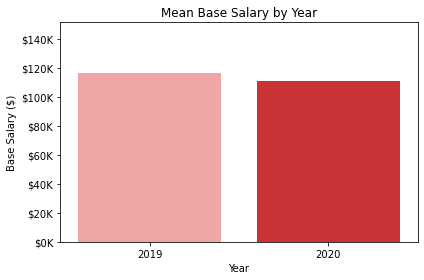

In [933]:
ds_agg_mean = reddit_ds_df.groupby(["year"]).aggregate("mean")
ds_agg_mean.reset_index(inplace=True)

ds_agg_median = reddit_ds_df.groupby(["year"]).aggregate("median")
ds_agg_median.reset_index(inplace=True)

ds_agg_ymax = (
    max(
        list(ds_agg_mean["salary_num"])
        + list(ds_agg_mean["total_comp_num"])
        + list(ds_agg_median["salary_num"])
        + list(ds_agg_median["total_comp_num"])
    )
    * 1.05
)

ds_comp_barplot(
    df=ds_agg_mean,
    sal_or_tc="sal",
    mean_or_med="mean",
    x_axis="year",
    y_max=ds_agg_ymax,
    export=True,
    facet=False,
)

Exporting to year_tc_mean_plot.png


<AxesSubplot:title={'center':'Mean Total Compensation by Year'}, xlabel='Year', ylabel='Total Compensation ($)'>

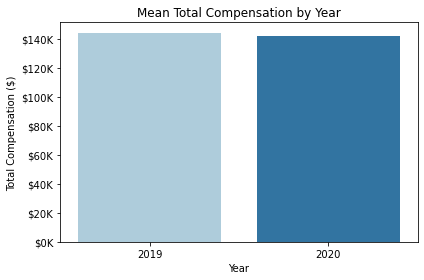

In [934]:
ds_comp_barplot(
    df=ds_agg_mean,
    sal_or_tc="tc",
    mean_or_med="mean",
    x_axis="year",
    y_max=ds_agg_ymax,
    export=True,
    facet=False,
)

Exporting to year_sal_median_plot.png


<AxesSubplot:title={'center':'Median Base Salary by Year'}, xlabel='Year', ylabel='Base Salary ($)'>

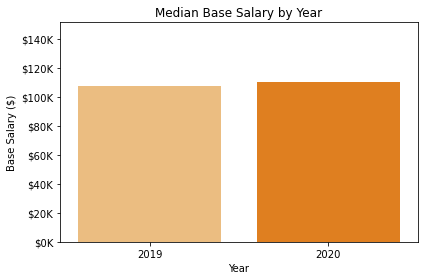

In [935]:
ds_comp_barplot(
    df=ds_agg_median,
    sal_or_tc="sal",
    mean_or_med="median",
    x_axis="year",
    y_max=ds_agg_ymax,
    export=True,
    facet=False,
)

Exporting to year_tc_median_plot.png


<AxesSubplot:title={'center':'Median Total Compensation by Year'}, xlabel='Year', ylabel='Total Compensation ($)'>

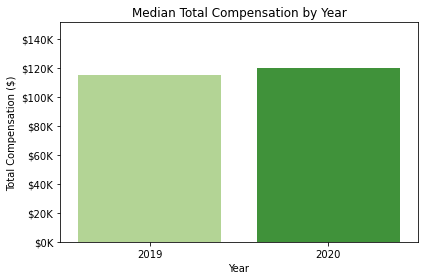

In [936]:
ds_comp_barplot(
    df=ds_agg_median,
    sal_or_tc="tc",
    mean_or_med="median",
    x_axis="year",
    y_max=ds_agg_ymax,
    export=True,
    facet=False,
)

In [937]:
title_table = reddit_ds_df.groupby(["year", "title_level"]).aggregate("count")
title_table.reset_index(inplace=True)
title_table[["year", "title_level", "index"]].pivot(
    index="title_level", columns="year", values="index"
)

year,2019,2020
title_level,,
analyst,21,10
scientist/engineer,50,49
senior,18,17
leader,6,5


Exporting to title_level_sal_mean_plot.png


<AxesSubplot:title={'center':'Mean Base Salary by Title Level'}, xlabel='Title Level', ylabel='Base Salary ($)'>

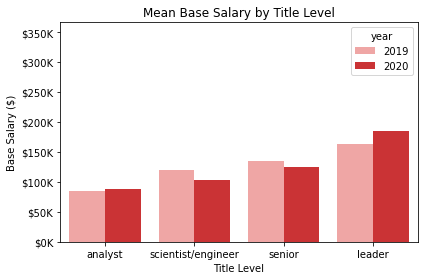

In [939]:
title_agg_mean = reddit_ds_df.groupby(["year", "title_level"]).aggregate("mean")
title_agg_mean.reset_index(inplace=True)

title_agg_median = reddit_ds_df.groupby(["year", "title_level"]).aggregate("median")
title_agg_median.reset_index(inplace=True)

title_agg_ymax = (
    max(
        list(title_agg_mean["salary_num"])
        + list(title_agg_mean["total_comp_num"])
        + list(title_agg_median["salary_num"])
        + list(title_agg_median["total_comp_num"])
    )
    * 1.05
)

ds_comp_barplot(
    df=title_agg_mean,
    sal_or_tc="sal",
    mean_or_med="mean",
    x_axis="title_level",
    y_max=title_agg_ymax,
    export=True,
    facet=True,
)

Exporting to title_level_tc_mean_plot.png


<AxesSubplot:title={'center':'Mean Total Compensation by Title Level'}, xlabel='Title Level', ylabel='Total Compensation ($)'>

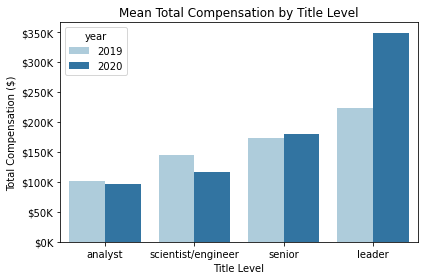

In [940]:
ds_comp_barplot(
    df=title_agg_mean,
    sal_or_tc="tc",
    mean_or_med="mean",
    x_axis="title_level",
    y_max=title_agg_ymax,
    export=True,
    facet=True,
)

Exporting to title_level_sal_median_plot.png


<AxesSubplot:title={'center':'Median Base Salary by Title Level'}, xlabel='Title Level', ylabel='Base Salary ($)'>

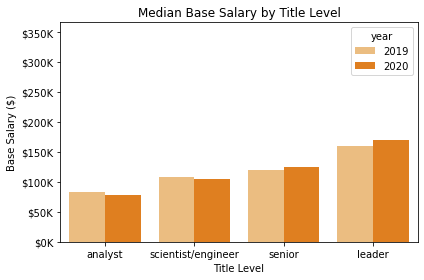

In [941]:
ds_comp_barplot(
    df=title_agg_median,
    sal_or_tc="sal",
    mean_or_med="median",
    x_axis="title_level",
    y_max=title_agg_ymax,
    export=True,
    facet=True,
)

Exporting to title_level_tc_median_plot.png


<AxesSubplot:title={'center':'Median Total Compensation by Title Level'}, xlabel='Title Level', ylabel='Total Compensation ($)'>

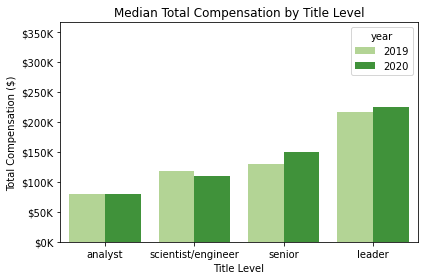

In [942]:
ds_comp_barplot(
    df=title_agg_median,
    sal_or_tc="tc",
    mean_or_med="median",
    x_axis="title_level",
    y_max=title_agg_ymax,
    export=True,
    facet=True,
)

In [890]:
tenure_table = reddit_ds_df.groupby(["year", "tenure_category"]).aggregate("count")
tenure_table.reset_index(inplace=True)
tenure_table[["year", "tenure_category", "index"]].pivot(
    index="tenure_category", columns="year", values="index"
)

year,2019,2020
tenure_category,,
< 1 year,8,3
1-2 years,66,55
> 2 years,15,19


222898.9
Exporting to tenure_category_sal_mean_plot.png


<AxesSubplot:title={'center':'Mean Base Salary by Tenure Category'}, xlabel='Tenure Category', ylabel='Base Salary ($)'>

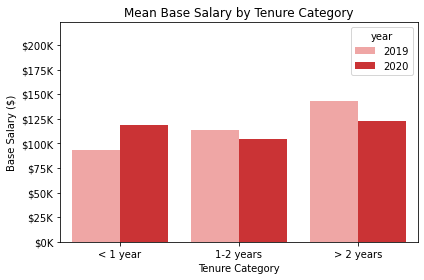

In [945]:
reddit_ds_tenure_df = reddit_ds_df[reddit_ds_df["tenure_category"] != "none given"]
tenure_agg_mean = reddit_ds_tenure_df.groupby(["year", "tenure_category"]).aggregate(
    "mean"
)
tenure_agg_mean.reset_index(inplace=True)

tenure_agg_median = reddit_ds_tenure_df.groupby(["year", "tenure_category"]).aggregate(
    "median"
)
tenure_agg_median.reset_index(inplace=True)

tenure_agg_ymax = (
    max(
        list(tenure_agg_mean["salary_num"])
        + list(tenure_agg_mean["total_comp_num"])
        + list(tenure_agg_median["salary_num"])
        + list(tenure_agg_median["total_comp_num"])
    )
    * 1.05
)

ds_comp_barplot(
    df=tenure_agg_mean,
    sal_or_tc="sal",
    mean_or_med="mean",
    x_axis="tenure_category",
    y_max=tenure_agg_ymax,
    export=True,
    facet=True,
)

Exporting to tenure_category_tc_mean_plot.png


<AxesSubplot:title={'center':'Mean Total Compensation by Tenure Category'}, xlabel='Tenure Category', ylabel='Total Compensation ($)'>

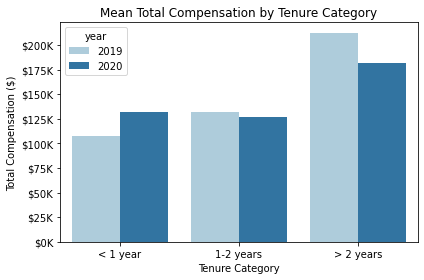

In [946]:
ds_comp_barplot(
    df=tenure_agg_mean,
    sal_or_tc="tc",
    mean_or_med="mean",
    x_axis="tenure_category",
    y_max=tenure_agg_ymax,
    export=True,
    facet=True,
)

Exporting to tenure_category_sal_median_plot.png


<AxesSubplot:title={'center':'Median Base Salary by Tenure Category'}, xlabel='Tenure Category', ylabel='Base Salary ($)'>

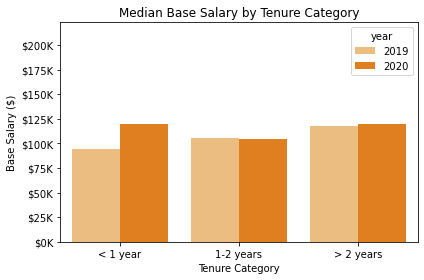

In [947]:
ds_comp_barplot(
    df=tenure_agg_median,
    sal_or_tc="sal",
    mean_or_med="median",
    x_axis="tenure_category",
    y_max=tenure_agg_ymax,
    export=True,
    facet=True,
)

Exporting to tenure_category_tc_median_plot.png


<AxesSubplot:title={'center':'Median Total Compensation by Tenure Category'}, xlabel='Tenure Category', ylabel='Total Compensation ($)'>

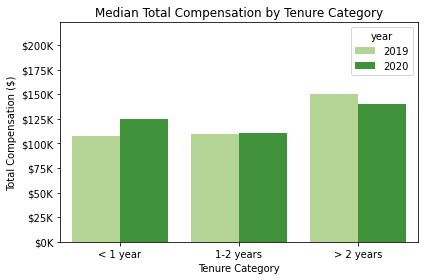

In [948]:
ds_comp_barplot(
    df=tenure_agg_median,
    sal_or_tc="tc",
    mean_or_med="median",
    x_axis="tenure_category",
    y_max=tenure_agg_ymax,
    export=True,
    facet=True,
)

In [892]:
location_table = reddit_ds_df.groupby(["year", "location_category"]).aggregate("count")
location_table.reset_index(inplace=True)
location_table[["year", "location_category", "index"]].pivot(
    index="location_category", columns="year", values="index"
)

year,2019,2020
location_category,,
international,11,18
bay area/seattle,20,12
west coast,14,6
south/midwest,30,18
east coast,19,23


Exporting to location_category_sal_mean_plot.png


<AxesSubplot:title={'center':'Mean Base Salary by Location Category'}, xlabel='Location Category', ylabel='Base Salary ($)'>

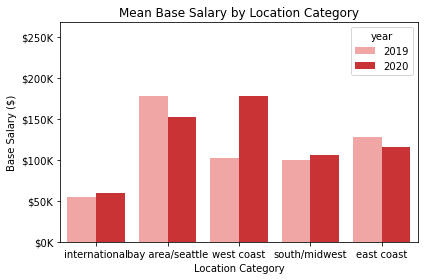

In [951]:
reddit_ds_location_df = reddit_ds_df[reddit_ds_df["location_category"] != "none given"]
location_agg_mean = reddit_ds_location_df.groupby(
    ["year", "location_category"]
).aggregate("mean")
location_agg_mean.reset_index(inplace=True)

location_agg_median = reddit_ds_location_df.groupby(
    ["year", "location_category"]
).aggregate("median")
location_agg_median.reset_index(inplace=True)

location_agg_ymax = (
    max(
        list(location_agg_mean["salary_num"])
        + list(location_agg_mean["total_comp_num"])
        + list(location_agg_median["salary_num"])
        + list(location_agg_median["total_comp_num"])
    )
    * 1.05
)

ds_comp_barplot(
    df=location_agg_mean,
    sal_or_tc="sal",
    mean_or_med="mean",
    x_axis="location_category",
    y_max=location_agg_ymax,
    export=True,
    facet=True,
)

Exporting to location_category_tc_mean_plot.png


<AxesSubplot:title={'center':'Mean Total Compensation by Location Category'}, xlabel='Location Category', ylabel='Total Compensation ($)'>

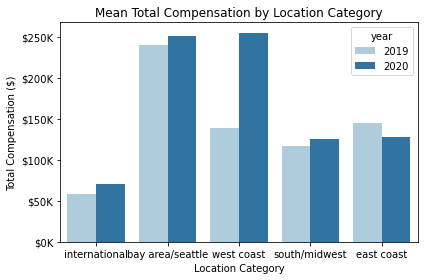

In [952]:
ds_comp_barplot(
    df=location_agg_mean,
    sal_or_tc="tc",
    mean_or_med="mean",
    x_axis="location_category",
    y_max=location_agg_ymax,
    export=True,
    facet=True,
)

Exporting to location_category_sal_median_plot.png


<AxesSubplot:title={'center':'Median Base Salary by Location Category'}, xlabel='Location Category', ylabel='Base Salary ($)'>

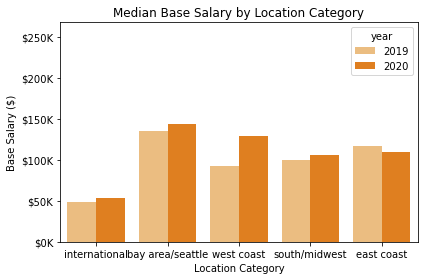

In [953]:
ds_comp_barplot(
    df=location_agg_median,
    sal_or_tc="sal",
    mean_or_med="median",
    x_axis="location_category",
    y_max=location_agg_ymax,
    export=True,
    facet=True,
)

Exporting to location_category_tc_median_plot.png


<AxesSubplot:title={'center':'Median Total Compensation by Location Category'}, xlabel='Location Category', ylabel='Total Compensation ($)'>

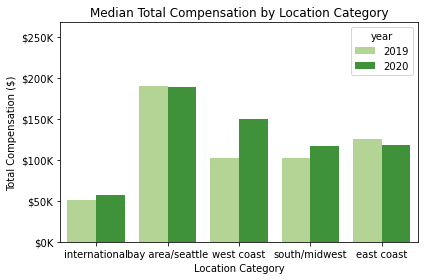

In [954]:
ds_comp_barplot(
    df=location_agg_median,
    sal_or_tc="tc",
    mean_or_med="median",
    x_axis="location_category",
    y_max=location_agg_ymax,
    export=True,
    facet=True,
)

In [893]:
industry_table = reddit_ds_df.groupby(["year", "industry_category"]).aggregate("count")
industry_table.reset_index(inplace=True)
industry_table[["year", "industry_category", "index"]].pivot(
    index="industry_category", columns="year", values="index"
)

year,2019,2020
industry_category,,
Finance/Insurance,19,17
Govt/Energy/Defense,8,8
Health/Pharmaceuticals,13,7
Other/Unknown,9,20
Retail/Ecommerce/Marketing/Logistics,15,8
Tech,32,21


Exporting to industry_category_sal_mean_plot.png


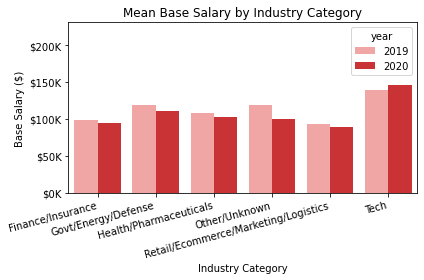

In [955]:
industry_agg_mean = reddit_ds_df.groupby(["year", "industry_category"]).aggregate(
    "mean"
)
industry_agg_mean.reset_index(inplace=True)

industry_agg_median = reddit_ds_df.groupby(["year", "industry_category"]).aggregate(
    "mean"
)
industry_agg_median.reset_index(inplace=True)

industry_agg_ymax = (
    max(
        list(industry_agg_mean["salary_num"])
        + list(industry_agg_mean["total_comp_num"])
        + list(industry_agg_median["salary_num"])
        + list(industry_agg_median["total_comp_num"])
    )
    * 1.05
)

industry_sal_mean_plot = ds_comp_barplot(
    df=industry_agg_mean,
    sal_or_tc="sal",
    mean_or_med="mean",
    x_axis="industry_category",
    y_max=industry_agg_ymax,
    export=True,
    facet=True,
)

industry_sal_mean_plot.set_xticklabels(
    industry_sal_mean_plot.get_xticklabels(), rotation=15, horizontalalignment="right"
)
plt.tight_layout()
plt.savefig("industry_category_sal_mean_plot.png", dpi=300)

Exporting to industry_category_tc_mean_plot.png


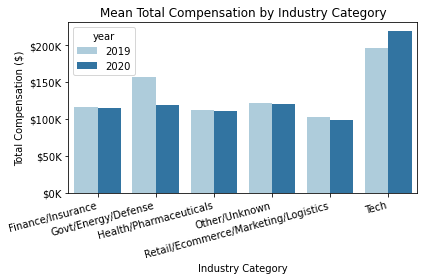

In [956]:
industry_tc_mean_plot = ds_comp_barplot(
    df=industry_agg_mean,
    sal_or_tc="tc",
    mean_or_med="mean",
    x_axis="industry_category",
    y_max=industry_agg_ymax,
    export=True,
    facet=True,
)

industry_tc_mean_plot.set_xticklabels(
    industry_tc_mean_plot.get_xticklabels(), rotation=15, horizontalalignment="right"
)
plt.tight_layout()
plt.savefig("industry_category_tc_mean_plot.png", dpi=300)

Exporting to industry_category_sal_median_plot.png


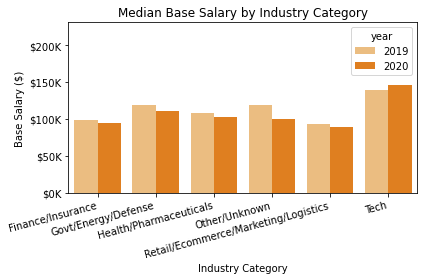

In [957]:
industry_sal_median_plot = ds_comp_barplot(
    df=industry_agg_median,
    sal_or_tc="sal",
    mean_or_med="median",
    x_axis="industry_category",
    y_max=industry_agg_ymax,
    export=True,
    facet=True,
)

industry_sal_median_plot.set_xticklabels(
    industry_sal_median_plot.get_xticklabels(), rotation=15, horizontalalignment="right"
)
plt.tight_layout()
plt.savefig("industry_category_sal_median_plot.png", dpi=300)

Exporting to industry_category_tc_median_plot.png


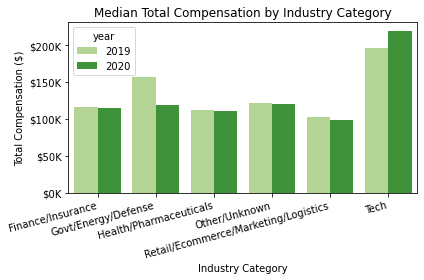

In [958]:
industry_tc_median_plot = ds_comp_barplot(
    df=industry_agg_median,
    sal_or_tc="tc",
    mean_or_med="median",
    x_axis="industry_category",
    y_max=industry_agg_ymax,
    export=True,
    facet=True,
)

industry_tc_median_plot.set_xticklabels(
    industry_tc_median_plot.get_xticklabels(), rotation=15, horizontalalignment="right"
)
plt.tight_layout()
plt.savefig("industry_category_tc_median_plot.png", dpi=300)

In [894]:
edu_table = reddit_ds_df.groupby(["year", "highest_education_category"]).aggregate(
    "count"
)
edu_table.reset_index(inplace=True)
edu_table[["year", "highest_education_category", "index"]].pivot(
    index="highest_education_category", columns="year", values="index"
)

year,2019,2020
highest_education_category,,
< bachelors,6,1
bachelors,27,22
masters,41,43
doctorate,22,15


Exporting to highest_education_category_sal_mean_plot.png


<AxesSubplot:title={'center':'Mean Base Salary by Highest Education Category'}, xlabel='Highest Education Category', ylabel='Base Salary ($)'>

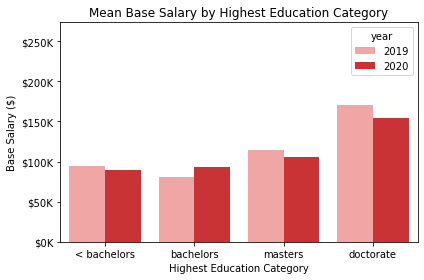

In [959]:
edu_agg_mean = reddit_ds_df.groupby(["year", "highest_education_category"]).aggregate(
    "mean"
)
edu_agg_mean.reset_index(inplace=True)

edu_agg_median = reddit_ds_df.groupby(["year", "highest_education_category"]).aggregate(
    "median"
)
edu_agg_median.reset_index(inplace=True)

edu_agg_ymax = (
    max(
        list(edu_agg_mean["salary_num"])
        + list(edu_agg_mean["total_comp_num"])
        + list(edu_agg_median["salary_num"])
        + list(edu_agg_median["total_comp_num"])
    )
    * 1.05
)

ds_comp_barplot(
    df=edu_agg_mean,
    sal_or_tc="sal",
    mean_or_med="mean",
    x_axis="highest_education_category",
    y_max=edu_agg_ymax,
    export=True,
    facet=True,
)

Exporting to highest_education_category_tc_mean_plot.png


<AxesSubplot:title={'center':'Mean Total Compensation by Highest Education Category'}, xlabel='Highest Education Category', ylabel='Total Compensation ($)'>

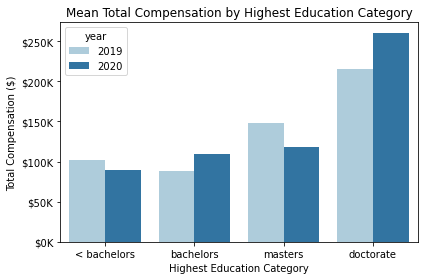

In [960]:
ds_comp_barplot(
    df=edu_agg_mean,
    sal_or_tc="tc",
    mean_or_med="mean",
    x_axis="highest_education_category",
    y_max=edu_agg_ymax,
    export=True,
    facet=True,
)

Exporting to highest_education_category_sal_median_plot.png


<AxesSubplot:title={'center':'Median Base Salary by Highest Education Category'}, xlabel='Highest Education Category', ylabel='Base Salary ($)'>

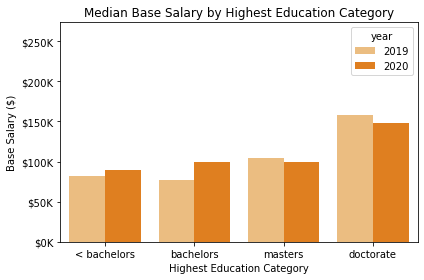

In [961]:
ds_comp_barplot(
    df=edu_agg_median,
    sal_or_tc="sal",
    mean_or_med="median",
    x_axis="highest_education_category",
    y_max=edu_agg_ymax,
    export=True,
    facet=True,
)

Exporting to highest_education_category_tc_median_plot.png


<AxesSubplot:title={'center':'Median Total Compensation by Highest Education Category'}, xlabel='Highest Education Category', ylabel='Total Compensation ($)'>

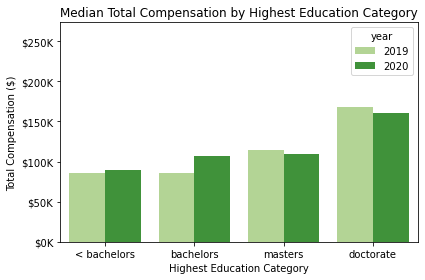

In [962]:
ds_comp_barplot(
    df=edu_agg_median,
    sal_or_tc="tc",
    mean_or_med="median",
    x_axis="highest_education_category",
    y_max=edu_agg_ymax,
    export=True,
    facet=True,
)